In [1]:
install.packages("cowplot") 
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)
library(cowplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks strin

In [2]:
install.packages("kknn")
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
set.seed(1)

In [4]:
# Create list of column names found in data/heart-disease.names
column_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# Read in data
dataset <- read_delim("https://raw.githubusercontent.com/tamzeedq/dsci-100_group_project/main/data/processed.cleveland.data", delim = ",", col_names = column_names)
head(dataset, 5) # Preview first 5 rows

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [5]:
updated_column_names <- c("age", "sex", "cp_type", "rest_bps", "chol", "fbs", "restecg", "max_heart_rate", "exang", "oldpeak", "slope", "ca", "thal", "presence")

colnames(dataset) <- updated_column_names # Updated the column names
updated_dataset <- dataset |>
            select(-ca, -thal) |> # Select every column except for ca and thal
            mutate(cp_type = as_factor(cp_type), presence = as_factor(presence)) # Convert column datatypes

head(updated_dataset, 5) # Preview first 5 rows

age,sex,cp_type,rest_bps,chol,fbs,restecg,max_heart_rate,exang,oldpeak,slope,presence
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0
67,1,4,160,286,0,2,108,1,1.5,2,2
67,1,4,120,229,0,2,129,1,2.6,2,1
37,1,3,130,250,0,0,187,0,3.5,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0


In [6]:
data_split <- initial_split(updated_dataset, prop = 0.75, strata = presence)  
training_data <- training(data_split)   
testing_data <- testing(data_split)

KNN Calculation

In [7]:

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
set_engine("kknn") |>
set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
knn_recipe <- recipe(presence ~ age + rest_bps + chol + max_heart_rate + cp_type, data = training_data)|>
step_center(age, rest_bps, chol, max_heart_rate)|>
step_scale(age, rest_bps, chol, max_heart_rate)
knn_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Centering for age, rest_bps, chol, max_heart_rate
Scaling for age, rest_bps, chol, max_heart_rate

In [13]:
knn_vfold <- vfold_cv(training_data, v = 5, strata = presence)

In [14]:
knn_fit <- workflow() |>
add_recipe(knn_recipe) |>
add_model(knn_spec) |>
tune_grid(resamples = knn_vfold, grid = tibble(neighbors = seq(from=1, to=15, by=1)))

knn_results <- knn_fit |>
collect_metrics()


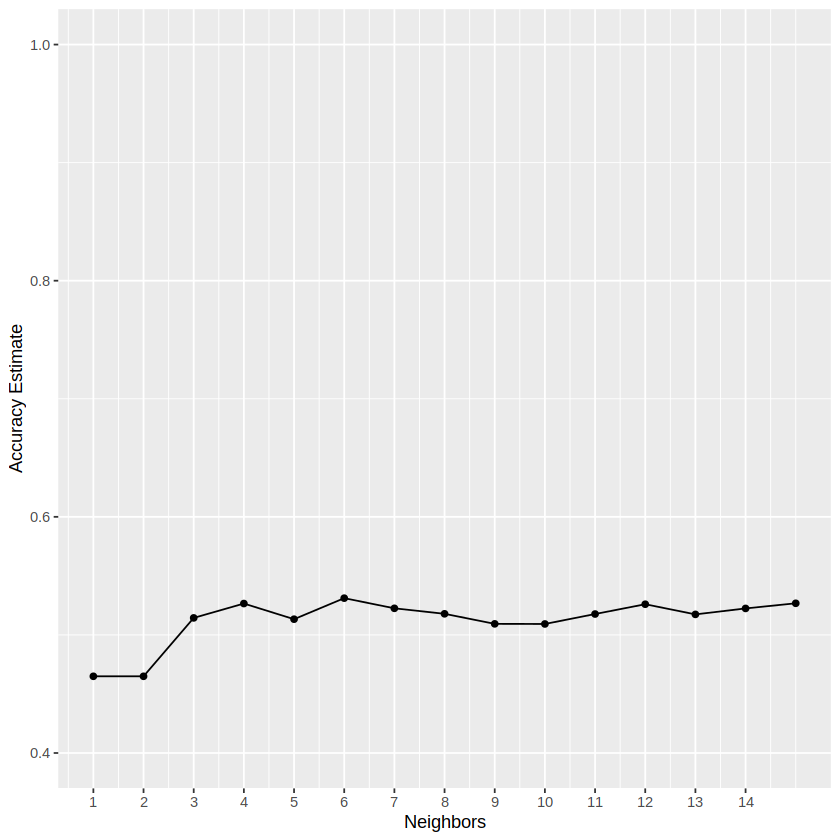

In [15]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

 From the accuracy graph, it can be observed that k=6 gives prediction that has highest accuracy.Therefore k=6 is a potential best k to use to build the model.

In [27]:
potential_k_spec<-nearest_neighbor(weight_func="rectangular", neighbors=6)|>
set_engine("kknn")|>
set_mode("classification")

fit_potential_k<-workflow()|>
add_recipe(knn_recipe)|>
add_model(potential_k_spec)|>
fit(data=training_data)

potential_k_prediction<-predict(fit_potential_k, testing_data)|>
bind_cols(testing_data)

confusion_potential_k<-potential_k_prediction|>
conf_mat(truth=presence, estimate=.pred_class)
confusion_potential_k

accuracy_potential_k<-potential_k_prediction |>
  metrics(truth = presence, estimate = .pred_class) |>
  filter(.metric == "accuracy")
accuracy_potential_k

          Truth
Prediction  0  1  2  3  4
         0 34  8  4  2  1
         1  4  0  3  4  1
         2  1  3  2  3  0
         3  1  2  1  0  1
         4  0  1  1  0  0

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4675325


Since the purpose of our classification model is to identify patients with heart diseases in order to guide them to medical support on time, it is very important for our model to be able to find presence of heart diseases from all observations. The recall of the model is what we want to maximize. 
To evaluate the performance of the model with k=7, we set the positive labels to be all labels except for 0 as they all indicate the presence of heart diseases just in different seriousness. 


Recall=number of correct positive prediction/total number of positive observations

To calculate the recall for the model, the total number of positive observation in testing data set is needed. 

In [28]:
presence_count_testing <- testing_data |>
                group_by(presence) |>
                summarize(count = n())
presence_count_testing

presence,count
<fct>,<int>
0,40
1,14
2,11
3,9
4,3


recall=22/37=59.46%


The recall of the model with k=7 is not good enough, a better k needs to be found. 